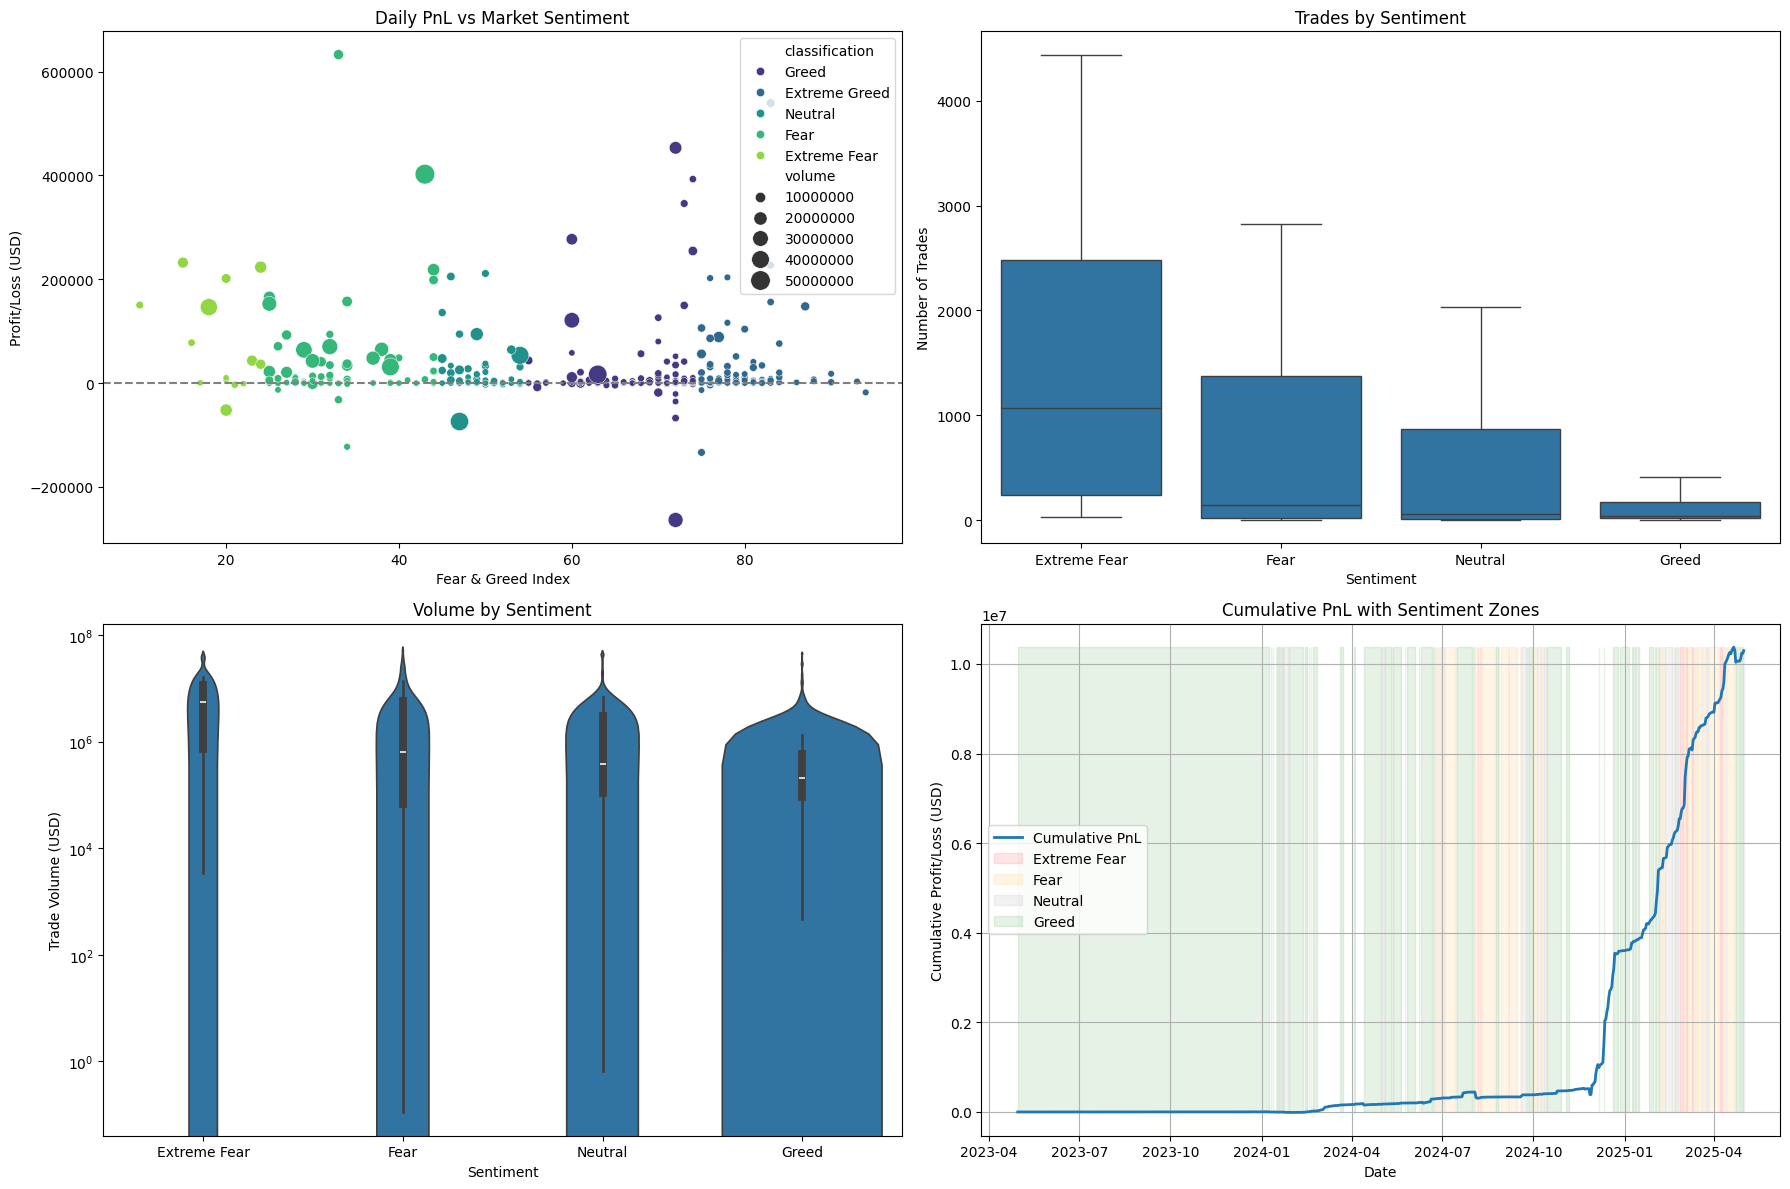


Correlation Matrix:
           value       pnl     count    volume
value   1.000000 -0.092624 -0.250671 -0.273569
pnl    -0.092624  1.000000  0.395385  0.331756
count  -0.250671  0.395385  1.000000  0.719297
volume -0.273569  0.331756  0.719297  1.000000

Performance by Sentiment:
                         pnl                                    count         \
                        mean        median           std         mean    sum   
classification                                                                 
Extreme Fear    76595.284088  39880.810976  95452.789407  1521.642857  21303   
Extreme Greed   23349.295452   3733.145935  67437.176873   358.750000  40180   
Fear            32224.900026   2678.839374  89547.007882   691.123596  61510   
Greed           12383.060871    765.690884  61670.485230   247.045685  48668   
Neutral         20344.137214   1781.631476  45368.089344   618.171875  39563   

                      volume                
                        mean   

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the CSV files
fgi = pd.read_csv('fear_greed_index.csv')
trades = pd.read_csv('historical_data.csv')

# Convert date columns
fgi['date'] = pd.to_datetime(fgi['date'])
fgi.set_index('date', inplace=True)

# Convert IST timestamp to UTC
trades['datetime_ist'] = pd.to_datetime(trades['Timestamp IST'], format='%d-%m-%Y %H:%M')
trades['datetime_utc'] = trades['datetime_ist'].dt.tz_localize('Asia/Kolkata').dt.tz_convert('UTC')
trades['date'] = pd.to_datetime(trades['datetime_utc'].dt.date)

# Group trades by date
daily = trades.groupby('date').agg({
    'Closed PnL': 'sum',
    'Account': 'count',
    'Size USD': 'sum'
}).rename(columns={
    'Closed PnL': 'pnl',
    'Account': 'count',
    'Size USD': 'volume'
})

# Merge FGI data with daily trades
common_dates = daily.index.intersection(fgi.index)
merged = pd.merge(daily, fgi, left_index=True, right_index=True, how='inner')

# Plot if data exists
if not merged.empty:
    plt.figure(figsize=(18, 12))

    # PnL vs Sentiment
    plt.subplot(2, 2, 1)
    sns.scatterplot(x='value', y='pnl', data=merged, hue='classification',
                    palette='viridis', size='volume', sizes=(20, 200))
    plt.title('Daily PnL vs Market Sentiment')
    plt.xlabel('Fear & Greed Index')
    plt.ylabel('Profit/Loss (USD)')
    plt.axhline(0, color='gray', linestyle='--')

    # Number of trades per sentiment
    plt.subplot(2, 2, 2)
    sns.boxplot(x='classification', y='count', data=merged,
                order=['Extreme Fear', 'Fear', 'Neutral', 'Greed'],
                showfliers=False)
    plt.title('Trades by Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Trades')

    # Volume by sentiment
    plt.subplot(2, 2, 3)
    sns.violinplot(x='classification', y='volume', data=merged,
                   order=['Extreme Fear', 'Fear', 'Neutral', 'Greed'])
    plt.title('Volume by Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Trade Volume (USD)')
    plt.yscale('log')

    # Cumulative PnL with sentiment zones
    plt.subplot(2, 2, 4)
    merged['cum_pnl'] = merged['pnl'].cumsum()
    plt.plot(merged.index, merged['cum_pnl'], label='Cumulative PnL', linewidth=2)

    colors = {
        'Extreme Fear': 'red',
        'Fear': 'orange',
        'Neutral': 'gray',
        'Greed': 'green'
    }
    for mood, color in colors.items():
        mask = merged['classification'] == mood
        plt.fill_between(merged.index, merged['cum_pnl'].min(), merged['cum_pnl'].max(),
                         where=mask, color=color, alpha=0.1, label=mood)

    plt.title('Cumulative PnL with Sentiment Zones')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Profit/Loss (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Stats
    print("\nCorrelation Matrix:")
    print(merged[['value', 'pnl', 'count', 'volume']].corr())

    print("\nPerformance by Sentiment:")
    summary = merged.groupby('classification').agg({
        'pnl': ['mean', 'median', 'std'],
        'count': ['mean', 'sum'],
        'volume': ['mean', 'sum']
    })
    print(summary)
else:
    print("No overlapping dates between trade data and sentiment index.")
